In [1]:
# =========================
# Libraries
# =========================

import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.integrate import trapezoid, cumulative_trapezoid
from scipy.interpolate import RegularGridInterpolator
import time
import emcee
from multiprocessing import Pool, cpu_count
import multiprocessing as mp
from getdist import MCSamples, plots
import matplotlib.pyplot as plt

In [2]:
# =========================
# Loading FRB data
# =========================

# Path
frb_dat_path = "/home/brunowesley/projetos/MCMC-cosmo/Data/FRB/frb_catalog.txt"

# DataFrame
df_frb = pd.read_csv(frb_dat_path, sep=r"\t", engine='python')

# Sort data by redshift
df_frb = df_frb.sort_values(by="Redshift", ascending=True)

# Reset index after sorting
df_frb = df_frb.reset_index(drop=True)

# Main columns
z_frb   = df_frb["Redshift"].to_numpy(float)
DM_obs  = df_frb["DM_obs"].to_numpy(float)
DM_MW   = df_frb["DM_MW_ISM_(NE2001)"].to_numpy(float)

# Milky Way halo contribution to the dispersion measure (literature value)
DM_halo_mean = 50

# Total Milky Way contribution to the dispersion measure
DM_MW_total = DM_MW + DM_halo_mean

# Extragalactic dispersion measure (IGM + host)
DM_ext_obs = DM_obs - DM_MW_total

In [3]:
# =========================
# Fiducial
# =========================

# Uniform priors 
H0_min, H0_max = 50.0, 90.0
Om0_min, Om0_max = 0.1, 0.6
Ob_min, Ob_max = 0.047, 0.052
b_min, b_max = 1.6, 8.0
sig_host_min, sig_host_max = 0.2, 2.0
e_mu_min, e_mu_max = 20.0, 200.0

# Gaussian prior
mu_Ob, sigma_Ob = 0.0495, 0.0025

# Physical constants (in SI units)
c_si = 2.99792458e8
G_si = 6.67430e-11
mp_si = 1.67262192369e-27

# Cosmological/astrophysical parameters
Or0 = 7.88e-5
f_IGM = 0.83
chi_e = 0.875

# Scalaron mass scale
delta_s = 1e-7

# Scale facor grid
ai, af, n_p = 0.2, 1.0, 1000
a_grid = np.linspace(ai, af, n_p)

# Redshift grid
zi, zf = 0.0, 4.0
z_grid = np.linspace(zi, zf, n_p)

In [4]:
# ==============================
# Stable numerical functions
# ==============================

# Stable log(cosh(x))
def stable_logcosh(x):

    # Absolute value of x
    abs_x = np.abs(x)

    # Switch to asymptotic form for numerical stability
    if abs_x < 20.0:
        return np.log(np.cosh(x))
    else:
        return abs_x - np.log(2.0)


# Stable tanh(x)
def stable_tanh(x):

    # Asymptotic saturation for large |x|
    if x > 20.0:
        return 1.0
    elif x < -20.0:
        return -1.0
    else:
        return np.tanh(x)


# Stable sech(x)
def stable_sech(x):
    
    # Absolute value of x
    abs_x = np.abs(x)
    
    # Switch to asymptotic form for numerical stability
    if abs_x < 20.0:
        return 1.0 / np.cosh(x)
    else:
        return 2.0 * np.exp(-abs_x)


# ============================================================
# Curvature scale in the AB f(R) model
# ============================================================

def compute_epsilon(H0, b):
    
    # Vacuum curvature scale
    R_vac = 12.0 * H0**2

    # Stable evaluation of log(1 + exp(2b))
    if b < 20.0:
        L = np.log1p(np.exp(2.0 * b))
    else:
        L = 2.0 * b + np.exp(-2.0 * b)

    return R_vac / L

In [5]:
# ============================================================
# ODE system for the Hubble parameter in the AB model
# ============================================================

def Hubble_AB_a(a, y, H0, Om0, b):
    """
    System of ordinary differential equations for the Hubble
    parameter H(a) in the AB f(R) gravity model.

    The system evolves H and its first two derivatives with
    respect to the scale factor a.
    """

    # Hubble parameter and its 1st and 2nd derivatives 
    H, dH, ddH = y

    # Matter and radiation density parameters
    Om = Om0 * a**(-3)
    Or = Or0 * a**(-4)

    # Effective curvature scale from the AB model
    epsilon = compute_epsilon(H0, b)

    # Squadred scalaron rest mass
    M2 = epsilon / delta_s

    # Ricci (curvature) scalar
    R = 6.0 * H * (2.0 * H + a * dH)

    # Normalized curvature scalar shifted by the model parameter b
    alpha = (R / epsilon) - b

    # Numerically stable hyperbolic functions
    tanh_a = stable_tanh(alpha)
    sech_a = stable_sech(alpha)


    # ===============================
    # ODE terms : A, B, C, D, E, F
    # ===============================

    A = H0**2 * (3.0 * Om + 4.0 * Or)

    B = a * H * dH * (tanh_a + 1.0)

    C = ( 4.0 * a * H**2 * dH * (a * dH + 2.0 * H) / M2 )

    D = ( ((6.0 * a**2 * H**2) / epsilon)**2 * ((5.0 * dH / a) + (dH**2 / H) + ddH)**2 * tanh_a * (sech_a**2) )

    E = ( 6.0 * a**3 * H**3 * (1.0 / (3.0 * M2) + 0.5 * (sech_a**2) / epsilon) )

    # Avoid singularities and non-finite evolution
    if E == 0 or not np.isfinite(E):
        return [np.nan, np.nan, np.nan]

    F = ( (11.0 * dH**2) / (a * H) + (dH**3) / (H**2) + (6.0 * ddH / a) + (4.0 * dH * ddH / H) )


    # 3rd derivative of the Hubble parameter
    dddH = -( (A + B + C - D) / E) - F

    # Return 1st, 2nd, and 3rd derivatives of H
    return [dH, ddH, dddH]


# ============================================================
# ODE integration for obtaining H(a)
# ============================================================

def H_AB_a(a_grid, H0, Om0, b):
    """
    Numerical solution for the Hubble parameter H(a) in the
    AB f(R) gravity model.

    The integration is initialized at a = a_i using LCDM
    initial conditions and evolved up to a = a_f.
    """

    # ---------------------------------
    # Initial conditions according to the LCDM model at ai = 0.2
    # ---------------------------------
    
    # Initial matter and radiation density parameters
    Omi = Om0 * ai**(-3)
    Ori = Or0 * ai**(-4)

    # Cosmological constant density parameter
    Ol0 = 1.0 - Om0 - Or0

    # Initial Hubble parameter H(ai)
    Hi = H0 * np.sqrt(Omi + Ori + Ol0)

    # Initial 1st derivative dH/da at ai
    dHi = - ( (H0**2) / (2.0 * ai * Hi) ) * (3.0 * Omi + 4.0 * Ori)

    # Initial 2nd derivative d²H/da² at ai
    ddHi = ( 0.5 * (H0 / (ai * Hi))**2 * (Hi + ai * dHi) * (3.0 * Omi + 4.0 * Ori)
        + 0.5 * (H0 / (ai * Hi))**2 * Hi * (9.0 * Omi + 16.0 * Ori) )

    # Initial state vector
    y0 = [Hi, dHi, ddHi]

    
    # ---------------------------------
    # Numerical integration
    # ---------------------------------

    sol = solve_ivp(Hubble_AB_a, (ai, af), y0, t_eval=a_grid, method="LSODA", rtol=1e-6, atol=1e-9, args=(H0, Om0, b))

    # Check integration success and numerical validity
    if sol.status < 0 or np.any(~np.isfinite(sol.y)):
        return None

    # Return H(a) evaluated on the input grid
    return sol.y[0]


# ============================================================
# Conversion to H(z)
# ============================================================

def H_AB_z(z_grid, H0, Om0, b):
    """
    Compute the Hubble parameter H(z) in the AB model.

    The function internally converts the redshift grid z
    into a scale factor grid a = 1 / (1 + z), solves the
    differential system in a, and maps the solution back
    to the original redshift ordering.
    """
    
    # Convert redshift grid to scale factor grid
    a_grid = 1.0 / (1.0 + z_grid)

    # Sort scale factor for monotonic integration
    sort_idx = np.argsort(a_grid)
    a_sorted = a_grid[sort_idx]

    # Solve for H(a) on the sorted grid
    H_sorted = H_AB_a(a_sorted, H0, Om0, b)
    if H_sorted is None:
        return None

    # Restore original redshift ordering
    H_z = np.empty_like(H_sorted)
    H_z[sort_idx] = H_sorted

    return H_z

In [6]:
# =========================
# Theoretical IGM dispersion measure
# =========================

def DM_IGM_AB(z_frb, H0, Om0, Ob, b):

    # Prefactor
    A = 3.0 * c_si * f_IGM * chi_e / (8.0 * np.pi * G_si * mp_si) 
    
    # Normalized Hubble parameter
    E_grid = H_AB_z(z_grid, H0, Om0, b) / H0
    
    # Integrand of the DM_IGM redshift integral
    integrand = (1 + z_grid) / E_grid

    # Cumulative integral over redshift
    I = cumulative_trapezoid(integrand, z_grid, initial=0.0)

    # Dispersion measure before unit conversion
    DM_IGM_prime = A * Ob * H0 * I

    # Unit conversion factors
    km_to_pc = 1.0 / (3.0857e13)
    m2_to_cm2 = 1e4
    Mpc_to_cm = 3.0857e24

    # Dispersion measure in physical units (pc cm^-3)
    DM_IGM_corr = DM_IGM_prime * (km_to_pc / (m2_to_cm2 * Mpc_to_cm))

    # Interpolate DM_IGM(z) at the FRB redshifts
    DM_IGM_theo = np.interp(z_frb, z_grid, DM_IGM_corr)
    
    return DM_IGM_theo


# ========================
# Sanity test
# ========================

print("DM_IGM_AB(z_frb) =", DM_IGM_AB(z_frb, 70, 0.3, 0.0495, 3))

DM_IGM_AB(z_frb) = [   7.03199077   15.76477652   19.67786344   24.79950044   25.16869023
   35.68348623   35.94608914   39.21038677   50.54031129   53.74747285
   54.08922348   55.37119112   58.87844897   60.00877576   60.16291123
   61.3631084    65.99971878   75.56698056   78.24733209   79.45973715
   83.01333899   89.09534994   91.48969285   91.62029337   93.451593
   96.85587836  100.24838971  100.79102399  100.87854565  104.20761423
  104.330353    107.89328309  108.33237364  110.35390389  110.96965433
  118.37099385  121.10876761  125.44331016  134.75941417  134.84836535
  135.95047053  138.22937891  152.87715402  158.88629889  165.99057624
  166.7110954   166.8282597   177.36159549  182.4314771   183.79070893
  186.51189756  199.70010296  204.26202265  206.54510108  209.28779089
  211.02336218  211.84990876  212.67370933  214.32213556  219.36490779
  219.54840884  230.39483236  238.23026157  243.2172328   245.15915041
  246.26881761  250.86845295  253.02853727  256.92337483  26

In [7]:
# ================================
# Grid for FRB Dispersion Measure
# ================================

n_H0 = n_Om0 = n_Ob = n_b = 8


def create_DM_grid(H0_range, Om0_range, Ob_range, b_range):

    start = time.time()

    H0_vals = np.linspace(*H0_range, n_H0)
    Om0_vals = np.linspace(*Om0_range, n_Om0)
    Ob_vals = np.linspace(*Ob_range, n_Ob)
    b_vals  = np.linspace(*b_range,  n_b)

    print(
        f"DM grid {n_H0}×{n_Om0}×{n_Ob}×{n_b} created "
        f"in {time.time()-start:.1f}s"
    )

    return H0_vals, Om0_vals, Ob_vals, b_vals


# ================================
# DM_IGM computation
# ================================

def DM_IGM_grid(z_grid, H0, Om0, Ob, b):

    A = 3.0 * c_si * f_IGM * chi_e / (8.0 * np.pi * G_si * mp_si)

    E_grid = H_AB_z(z_grid, H0, Om0, b) / H0

    if np.any(~np.isfinite(E_grid)) or np.any(E_grid <= 0.0):
        return None

    integrand = (1.0 + z_grid) / E_grid
    I = cumulative_trapezoid(integrand, z_grid, initial=0.0)

    DM_prime = A * Ob * H0 * I

    km_to_pc  = 1.0 / 3.0857e13
    m2_to_cm2 = 1e4
    Mpc_to_cm = 3.0857e24

    DM_corr = DM_prime * (km_to_pc / (m2_to_cm2 * Mpc_to_cm))

    return DM_corr


# ================================
# Worker
# ================================

def DM_worker(args):
    i, j, k, l, H0, Om0, Ob, b, z_grid = args

    DMz = DM_IGM_grid(z_grid, H0, Om0, Ob, b)

    if DMz is None:
        DMz = np.full(len(z_grid), np.nan)

    return i, j, k, l, DMz


# ================================
# Build the full 5D DM grid (parallel)
# ================================

H0_vals, Om0_vals, Ob_vals, b_vals = create_DM_grid(
    (H0_min, H0_max),
    (Om0_min, Om0_max),
    (Ob_min, Ob_max),
    (b_min, b_max)
)

DM_array = np.zeros(
    (len(H0_vals),
     len(Om0_vals),
     len(Ob_vals),
     len(b_vals),
     len(z_grid))
)

# Build task list
tasks = []
for i, H0 in enumerate(H0_vals):
    for j, Om0 in enumerate(Om0_vals):
        for k, Ob in enumerate(Ob_vals):
            for l, b in enumerate(b_vals):
                tasks.append((i, j, k, l, H0, Om0, Ob, b, z_grid))

total = len(tasks)

n_cores = max(cpu_count() - 1, 1)
print(f"Computing DM grid in parallel using {n_cores} cores...")

start = time.time()
count = 0
last_pct = 0

with Pool(processes=n_cores) as pool:
    for result in pool.imap_unordered(DM_worker, tasks):

        i, j, k, l, DMz = result
        DM_array[i, j, k, l, :] = DMz

        count += 1
        pct = int(100 * count / total)

        if pct >= last_pct + 10 or count == total:
            elapsed = time.time() - start
            eta = elapsed / count * (total - count)
            print(f"{pct}% | elapsed {elapsed:.1f}s | ETA {eta:.1f}s")
            last_pct = pct

print(f"DM grid computation completed in {time.time()-start:.1f}s")


# ================================
# 5D interpolator
# ================================

DM_interp_5D = RegularGridInterpolator(
    (H0_vals, Om0_vals, Ob_vals, b_vals, z_grid),
    DM_array,
    bounds_error=False,
    fill_value=None
)

DM grid 8×8×8×8 created in 0.0s
Computing DM grid in parallel using 111 cores...
10% | elapsed 1.4s | ETA 12.2s
20% | elapsed 2.2s | ETA 8.7s
30% | elapsed 3.0s | ETA 7.0s
40% | elapsed 3.8s | ETA 5.7s
50% | elapsed 4.6s | ETA 4.6s
60% | elapsed 5.5s | ETA 3.7s
70% | elapsed 6.3s | ETA 2.7s
80% | elapsed 7.1s | ETA 1.8s
90% | elapsed 8.0s | ETA 0.9s
100% | elapsed 8.7s | ETA 0.0s
DM grid computation completed in 8.8s


In [8]:
# ============================================================
# Dispersion measure interpolator
# ============================================================

def DM_IGM_AB_interp(z_frb, H0, Om0, Ob, b):
    """
    Fast evaluation of the FRB intergalactic dispersion measure
    using the precomputed 5D interpolator.
    """

    pts = np.column_stack([
        np.full_like(z_frb, H0),
        np.full_like(z_frb, Om0),
        np.full_like(z_frb, Ob),
        np.full_like(z_frb, b),
        z_frb
    ])

    return DM_interp_5D(pts)


#  ========================
# Sanity test
# ========================

print("DM_IGM_AB_interp(z_frb) =", DM_IGM_AB_interp(z_frb, 70, 0.3, 0.0495, 3))

DM_IGM_AB_interp(z_frb) = [   7.02297794   15.74459899   19.65269426   24.76781095   25.13653124
   35.63798968   35.90026025   39.16043223   50.47609494   53.67923716
   54.02056029   55.30092488   58.80380176   59.93271835   60.08666152
   61.28536344   65.91620884   75.47163674   78.14868805   79.35960398
   82.90884705   88.98342821   91.37485673   91.50529828   93.33437526
   96.73453636  100.12295098  100.66493125  100.75234742  104.07741164
  104.20000299  107.75866271  108.19722776  110.2163432   110.83135942
  118.22390751  120.95844721  125.28789039  134.59312078  134.68196888
  135.78279678  138.05906702  152.69007666  158.69243759  165.78877102
  166.50848912  166.6255235   177.14724855  182.21161208  183.56937037
  186.28762231  199.46177786  204.01891402  206.29961032  209.03945561
  210.77323438  211.59892957  212.42188159  214.06861483  219.10624396
  219.28955864  230.12509415  237.9528076   242.9349327   244.87498178
  245.98358126  250.57882611  252.73686666  256.628

In [9]:
# =========================
# FRB Likelihood
# =========================

# Log-priors
def lnprior_frb(theta_frb):

    # Params vector
    H0, Om0, Ob, b, sigma_host, exp_mu = theta_frb
    
    # Flat priors
    if not (H0_min <= H0 <= H0_max):                     return -np.inf
    if not (Om0_min <= Om0 <= Om0_max):                  return -np.inf
    if not (b_min <= b <= b_max):                        return -np.inf
    if not (sig_host_min <= sigma_host <= sig_host_max): return -np.inf
    if not (e_mu_min <= exp_mu <= e_mu_max):             return -np.inf
   
    # Gaussion prior on Omega_b
    lp_Ob = -0.5 * ((Ob - mu_Ob) / sigma_Ob)**2 - np.log(sigma_Ob * np.sqrt(2.0 * np.pi))

    return lp_Ob


# Convolved FRB PDF: IGM (Gaussian) + host galaxy (log-normal)
def P_DM_ext_vectorized(z_frb, DM_ext_obs, DM_IGM_mean, sigma_IGM, sigma_host, exp_mu, npts=600):
    
    # Number of FRBs
    N = len(DM_ext_obs)

    # Log-normal mean of the host contribution
    mu_host = np.log(exp_mu)

    # DM_host integration grid
    DM_hosp_grid = np.linspace(1e-5, DM_ext_obs.max(), npts)   # (npts,)
    DM_hosp_grid = DM_hosp_grid[None, :]                       # (1, npts)

    # Observed extragalactic DM
    DM_ext_array = DM_ext_obs[:, None]  # (N, 1)

    # DM_IGM for each host contribution
    DM_IGM_array = DM_ext_array - DM_hosp_grid / (1 + z_frb[:, None])  # (N, npts)

    # IGM dispersion
    sigma_IGM_array = sigma_IGM[:, None]
    
    # DM_IGM mean
    DM_IGM_mean_array = DM_IGM_mean[:, None]
    
    # IGM PDF (Gaussian)
    P_IGM = (1.0 / (np.sqrt(2*np.pi) * sigma_IGM_array)) \
            * np.exp(-0.5 * ((DM_IGM_array - DM_IGM_mean_array)/sigma_IGM_array)**2)

    # Host galaxy PDF (log-normal)
    DM_hosp_array = DM_hosp_grid
    P_host = (1.0 / (np.sqrt(2*np.pi) * sigma_host * DM_hosp_array)) \
             * np.exp(-0.5 * ((np.log(DM_hosp_array) - mu_host)/sigma_host)**2)

    # Product of IGM and host PDFs
    integrand = P_IGM * P_host  # (N, npts)

    # Marginalization over DM_host
    P_total = trapezoid(integrand, x=DM_hosp_array, axis=1)

    # Avoid log(0)
    return np.maximum(P_total, 1e-100)


# Log-likelihood
def lnlike_frb(theta_frb, z_frb, DM_ext_obs, npts=1000):
    H0, Om0, Ob, b, sigma_host, exp_mu = theta_frb

    # Theoretical mean IGM Dispersion measure
    # DM_IGM_mean = DM_IGM_wCDM(z_frb, H0, Om0, Ob, b)
    DM_IGM_mean = DM_IGM_AB_interp(z_frb, H0, Om0, Ob, b)

    # Empirical IGM scatter
    sigma_IGM = 173.8 * (z_frb**0.4)

    # IGM + host convolution
    P_total = P_DM_ext_vectorized(z_frb, DM_ext_obs, DM_IGM_mean,sigma_IGM, sigma_host, exp_mu, npts=npts)
    
    return np.sum(np.log(P_total))


# Log-posterior
def lnprob_frb(theta_frb, z_frb, DM_ext_obs):
    
    # Log-prior
    lp = lnprior_frb(theta_frb)
    if not np.isfinite(lp):
        return -np.inf

    # Log-likelihood
    ll = lnlike_frb(theta_frb, z_frb, DM_ext_obs, npts=1000)

    return lp + ll


# =========================
# Quick test
# =========================

theta_frb_test = [70, 0.3, 0.0494, 3, 0.7, 120]
print("AB_FRB log-posterior =", lnprob_frb(theta_frb_test, z_frb, DM_ext_obs))

AB_FRB log-posterior = -645.4022811643849


In [10]:
# =========================
# MCMC configuration
# =========================

# Dimensions and sampling settings
ndim, nwalkers, nsteps, nburn = 6, 40, 53500, 3500
rng = np.random.default_rng(42)

# Initial walker positions drawn from priors
p0 = np.zeros((nwalkers, ndim))
p0[:,0] = rng.uniform(H0_min,H0_max,nwalkers)               # Uniform H0
p0[:,1] = rng.uniform(Om0_min,Om0_max,nwalkers)             # Uniform Omega_m0
p0[:,2] = rng.normal(mu_Ob,sigma_Ob,nwalkers)               # Gaussian Omega_b
p0[:,3] = rng.uniform(b_min,b_max,nwalkers)                 # Uniform b
p0[:,4] = rng.uniform(sig_host_min,sig_host_max,nwalkers)   # Uniform sigma_host
p0[:,5] = rng.uniform(e_mu_min,e_mu_max,nwalkers)           # Uniform exp_mu

# Parallel chain generation (MORE efficient for AB_FRB)
with mp.Pool(processes=nwalkers) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_frb, args=(z_frb, DM_ext_obs), pool=pool)
    sampler.run_mcmc(p0, nsteps, progress=True)

# Single-threaded chain generation (LESS efficient for AB_FRB)
# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_frb, args=(z_frb, DM_ext_obs))
# sampler.run_mcmc(p0, nsteps, progress=True)


# Full chain: shape (nsteps, nwalkers, ndim)
chain = sampler.get_chain()
# np.save("chain_AB_frb_grid.npy", chain)

# Flattened chain after burn-in: shape (N_total, ndim)
flat_samples = sampler.get_chain(discard=nburn, flat=True)
np.save("flat_samples_AB_frb_grid.npy", flat_samples)

100%|██████████| 53500/53500 [11:05<00:00, 80.42it/s]


Removed no burn in


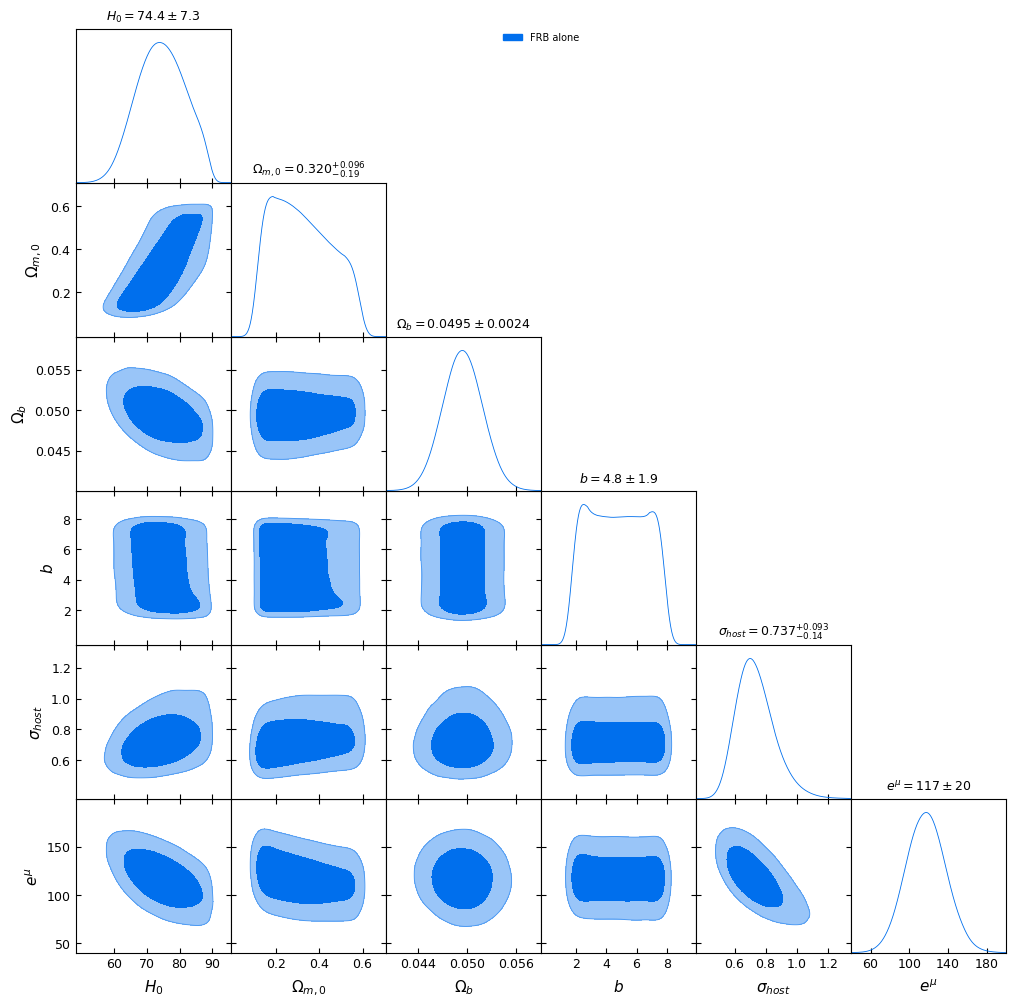

In [11]:
# =========================
# Corner plot using GetDist
# =========================

# Parameter names and LaTeX labels
param_names  = ["H0", "Omega_m0", "Omega_b", "b", "sigma_host", "exp_mu"]
param_labels = [r"H_0", r"\Omega_{m,0}", r"\Omega_b", r"b", r"\sigma_{host}", r"e^\mu"]


# Create GetDist samples object
samples = MCSamples(
    samples=flat_samples,
    names=param_names,
    labels=param_labels
)

# Smoothing and binning settings
samples.updateSettings({
    "smooth_scale_1D": 0.25,
    "smooth_scale_2D": 0.25,
    "fine_bins": 1024,
    "fine_bins_2D": 1024

})

# Parameter ranges (optional)
# samples.setRanges({
#     "param p1": (p1_min, p1_max),
#     "param p2": (p2_min, p2_max),
#     "param p3": (p3_min, p3_max)
# })


# Initialize GetDist subplot plotter
g = plots.get_subplot_plotter()

# Plot styling settings
g.settings.axes_fontsize = 12
g.settings.lab_fontsize = 14
g.settings.legend_fontsize = 10
g.settings.linewidth_contour = 1.2
g.settings.num_plot_contours = 2
g.settings.axis_marker_lw = 1.0
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.3


# Triangle (corner) plot
g.triangle_plot(
    samples,
    filled=True,
    legend_labels=["FRB alone"],
    #contour_colors=["#"],
    title_limit=1
)

# Save figure
plt.savefig("triangle_AB_frb_grid.png", dpi=300, bbox_inches="tight")
plt.show()